# Praat
Functions and info for pulling features from a wav file using Praat

In [2]:
import parselmouth

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set() # Use seaborn's default style to make attractive graphs

import os

In [2]:
#import subprocess

#def getSome(fileName):
#    process = subprocess.run(['Praat.exe', '--run', '--utf8', 'PitchTest1.praat', fileName], capture_output=True)
#    return process.stdout.decode("utf-8")

#print(getSome('Record_0002.wav'))

['1-impolite.wav', '1-polite.wav', '2-impolite.wav', '3-impolite.wav', '3-polite.wav', '4-impolite.wav', '4-polite.wav', '5-impolite.wav', '5-polite.wav', '6-impolite.wav', '6-polite.wav', '7-impolite.wav', '7-polite.wav', '8-impolite.wav', '8-polite.wav', 'name.wav']


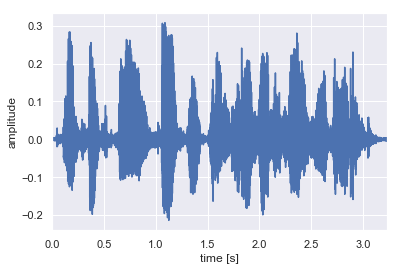

In [16]:
# Plot nice figures using Python's "standard" matplotlib library
files = list(filter(lambda x: x.endswith('.wav'), os.listdir('../Audio/Yuebai Gao/')))

for(file in files)
snd = parselmouth.Sound(file)
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

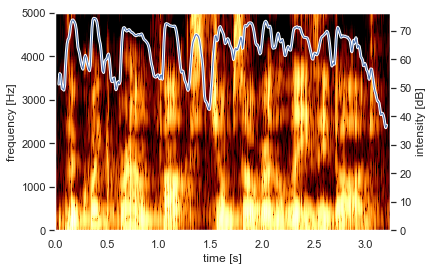

In [5]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show() # or plt.savefig("spectrogram.pdf")

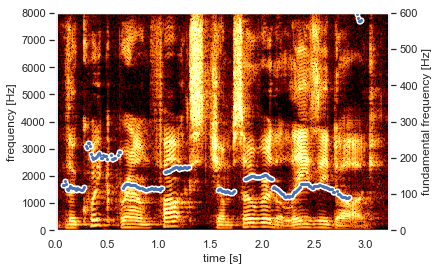

In [6]:
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

pitch = snd.to_pitch()
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show() # or plt.savefig("spectrogram_0.03.pdf")


In [3]:
def evaluate(basefile, keyfile):
    #Basic evaluation of key file
    snd = parselmouth.Sound(keyfile)

    intensity = snd.to_intensity()
    pitch = snd.to_pitch()

    intensityxs = intensity.xs()
    pitchxs = pitch.xs()

    intensityindex = 0;
    pitchindex = 0;

    pitch_values = pitch.selected_array['frequency'];
    intensity_values = intensity.values[0]

    result = "";

    while (pitchindex < len(pitchxs) and intensityindex < len(intensityxs)):
        if(intensityindex >= len(intensityxs) or pitchxs[pitchindex] < intensityxs[intensityindex]):
            result += str(pitchxs[pitchindex]) + ", " +str(pitch_values[pitchindex])+', '+str(intensity_values[intensityindex])+'\n';
            pitchindex += 1;
        elif(pitchindex >= len(pitchxs) or pitchxs[pitchindex] > intensityxs[intensityindex]):
            result += str(intensityxs[intensityindex]) + ", " +str(pitch_values[pitchindex])+', '+str(intensity_values[intensityindex])+'\n';
            intensityindex += 1;
        elif(pitchxs[pitchindex] == intensityxs[intensityindex]):
            result += str(intensityxs[intensityindex]) + ", " +str(pitch_values[pitchindex])+', '+str(intensity_values[intensityindex])+'\n';
            intensityindex += 1;
            pitchindex += 1;
    
    #Create output of basic evaluation
    filename = os.path.basename(keyfile) + ".csv";
    file = open(filename, 'w');
    file.write(result);
    file.close();
    
    return (filename, 1);

evaluate("","Record_0002.wav")

('Record_0002.wav.csv', 1)

# Running the Model
Functions, imports, and info for training and running a model to calculate how polite a wav file is.

Will likely rely on the Praat section.

In [9]:
#From: https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

#From: https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

In [55]:
def data_process(csvfile):
    num_lines = 0
    
    pitch=[]
    volume=[]    
    plot=open(csvfile)
    for row in plot:
        arr=row.split(',')
        pitch.append(arr[1]) 
        volume.append(arr[2][0:17])
        num_lines+=1
    size=int(num_lines/9)
    
    sum1=0
    sum2=0
    pitch1=[]
    volume1=[]
    a=0
    b=size
    for j in range(9):
        for i in range(a,b):
           sum1+=float(pitch[i])
           sum2+=float(volume[i])
        data1=sum1/size
        data2=sum2/size
        pitch1.append(data1)
        volume1.append(data2)
        a=b
        b=b+size
        sum1=0
        sum2=0
    
    sum1=0
    sum2=0
    for i in range(a+1,len(pitch)):
        sum1+=float(pitch[i])
        sum2+=float(volume[i])
    s=len(pitch)-a
    data1=sum1/s
    data2=sum2/s
    pitch1.append(data1)
    volume1.append(data2)
    print(pitch1)
    print(volume1)
    return(pitch1,volume1)
        
data_process('Record_0002.wav.csv')

[125.68439115874679, 150.24209457264757, 112.01098185174524, 106.22449768016095, 49.07953330098652, 125.40211947645406, 110.51275225158828, 103.81777842319451, 84.7259090653824, 0.0]
[62.41317704796553, 61.963922739797916, 63.41123642080403, 63.26914063367399, 61.117117725028145, 68.66557057370866, 66.92431099623681, 65.72462759861136, 55.55651813351845, 27.239055683962725]


([125.68439115874679,
  150.24209457264757,
  112.01098185174524,
  106.22449768016095,
  49.07953330098652,
  125.40211947645406,
  110.51275225158828,
  103.81777842319451,
  84.7259090653824,
  0.0],
 [62.41317704796553,
  61.963922739797916,
  63.41123642080403,
  63.26914063367399,
  61.117117725028145,
  68.66557057370866,
  66.92431099623681,
  65.72462759861136,
  55.55651813351845,
  27.239055683962725])

In [ ]:
#We need to define X as the features (spectrogram values for example)
#We need to define y as the target values (aka the class, either polite or impolite)

#X should be a 2D array where each row corresponds to the inputs for a single piece of data (including the bias)
#y should be a 2D array where each row is an array with one binary value (the expected output for the coresponding row of X)


In [ ]:
#Here we train the model
#From: https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24

model = LogisticRegression()
#model.fit(X, y)
#predicted_classes = model.predict(X)
#accuracy = accuracy_score(y.flatten(),predicted_classes)
#parameters = model.coef_